<a href="https://colab.research.google.com/github/harnalashok/Clustering/blob/master/online_retail_rfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 17th April, 2021
# Ref: https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering
# My folder:
# github: harnalashok/clustering/
#
# Objectives:
#            i) Feature engineering before clustering
#           ii) Outlier detection techniques
#                 a) Using IQR (Tukey's fences)
#                 b) Using region rejection & confidence interval
#                 c) Using machine learning for anomaly detection
#                    (isolation forests)
#          iii) Box-cox transformations
#           iv) Agglomerative clustering
#            v) KMeans clustering
#           vi) Gaussian Mixture modeling
# 

### Transform data
Transform and visualize data

#### Call libraries

In [82]:
# 1.0 Import required libraries for dataframe and visualization

import numpy as np
import pandas as pd

# 1.0.1 Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 1.0.2 import required libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# 1.0.3 Boxcox transform function
from sklearn.preprocessing import power_transform

# 1.0.4
import os
%matplotlib inline
from scipy import stats

In [2]:
# 1.1 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read and explore

In [3]:
# 1.1.2 My data folder
path = "/content" 
os.chdir(path)
os.listdir()

['.config', 'onlineretail.zip', 'sample_data']

In [4]:
# 1.2 Read Data
data = pd.read_csv(
                   #"OnlineRetail.csv",
                   "onlineretail.zip",
                   encoding = "ISO_8859_1", # utf_8
                   engine = 'python', # Takes time but reads full file
                                      # 'c' engine is faster but has problems
                                      # at separators. Default is 'c'
                   header = 0
                   #parse_dates=True        # InvoiceDate does not get converted to date
                   )


In [5]:
# 1.2.1 
data.shape   # (541909, 8)
print()
data.dtypes  
print()
data.head()
data['StockCode'].value_counts()

(541909, 8)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


85123A      2313
22423       2203
85099B      2159
47566       1727
20725       1639
            ... 
DCGS0057       1
84526          1
35969          1
85036a         1
85023C         1
Name: StockCode, Length: 4070, dtype: int64

In [6]:
# 1.2.2 Transform InvoiceDate dtype to datetype
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
# 1.2.3 Examine data
print("\n-----InvoiceNo------\n")
data.InvoiceNo.value_counts()     # 25900 unique
print()
print("\n-----StockCode------\n")
data.StockCode.value_counts()     # 4070  unique
print()
print("\n----CustomerID-------\n")
data.CustomerID.value_counts()    # 4372 unique
print("\n----Country-------\n")
data.Country.value_counts()       # 38 unique
print()
len(data.Country.value_counts())  # 38 unique


-----InvoiceNo------



573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554696        1
573121        1
C551336       1
559319        1
549145        1
Name: InvoiceNo, Length: 25900, dtype: int64



-----StockCode------



85123A      2313
22423       2203
85099B      2159
47566       1727
20725       1639
            ... 
DCGS0057       1
84526          1
35969          1
85036a         1
85023C         1
Name: StockCode, Length: 4070, dtype: int64



----CustomerID-------



17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64


----Country-------



United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

38

In [8]:
# 1.2.4 Are there NAs?
data.isnull().sum()   # Yes, there are

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# 1.3 Cleanup data. Remove those 
#     rows where no CustomerIDs

data = data[~data["CustomerID"].isnull()]
data.shape  # (406829, 8)

(406829, 8)

In [10]:
# 1.4 Checking for duplicates. Remove duplicates:

data = data[~data.duplicated()]
data.shape   # (401604, 8)  ; data.drop_duplicates(keep='first', inplace=True)

(401604, 8)

In [11]:
# 1.5 Let us see max and min dates:

data.sort_values(by = "InvoiceDate", ascending = False).head()
data.sort_values(by = "InvoiceDate",ascending = False).tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
394691,570876,23083,SET 6 PAPER TABLE LANTERN STARS,2,2011-12-10 17:19:00,3.75,16085.0,United Kingdom
394690,570876,22469,HEART OF WICKER SMALL,3,2011-12-10 17:19:00,1.65,16085.0,United Kingdom
394694,570876,23509,MINI PLAYING CARDS FUN FAIR,4,2011-12-10 17:19:00,0.42,16085.0,United Kingdom
394695,570876,23048,SET OF 10 LANTERNS FAIRY LIGHT STAR,2,2011-12-10 17:19:00,4.15,16085.0,United Kingdom
394696,570876,23503,PLAYING CARDS KEEP CALM & CARRY ON,4,2011-12-10 17:19:00,1.25,16085.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-01-12 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-01-12 08:26:00,4.25,17850.0,United Kingdom
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom


In [12]:
# 1.6 Revenue generated, per row:
#     Create a new column

data['rev'] = data['UnitPrice'] * data['Quantity']

#### Univariate distributions
Plotting with [plotly express](https://plotly.com/python/plotly-express/)

In [13]:
# 2.0 Our data is huge. Sample it
small = data.sample(frac=0.1)
small.shape

(40160, 9)

In [14]:
# 2.1
# https://plotly.com/python/histograms/
# https://plotly.com/python/axes/
fig = px.histogram(small, x = "rev")
fig.update_xaxes(range=[0, 1000])
#fig.show()
#sns.displot(data = small, x = "rev")


In [15]:
# 2.2
# https://plotly.com/python/box-plots/
fig = px.box(small, y='rev')
fig.show()

In [16]:
# 2.3 Country wise distribution
fig = px.box(small, x = 'Country',y='rev')
fig.show()

#### Feature Engineering to get RFM data: Extract data

##### Recency first


In [17]:
# 2.0
df = data.copy()

In [18]:
# 2.1 
grd = df.groupby("CustomerID")

In [19]:
# 2.2
df_recency = grd['InvoiceDate'].max().reset_index()
df_recency.head()
df_recency.shape   # (4372, 2)

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-10-31 12:25:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


(4372, 2)

In [20]:
# 2.3 Examine extracted information:

df_recency.shape     # (4372,2)
print()
df_recency.head()
print()
df_recency[['CustomerID', 'InvoiceDate']].head()
print()
df_recency['InvoiceDate'].min()
print()
df_recency['recency']= (df_recency['InvoiceDate'].max() - df_recency['InvoiceDate'])/ pd.Timedelta("1 days")
print()
df_recency = df_recency[['CustomerID', 'recency']]

(4372, 2)

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-10-31 12:25:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-10-31 12:25:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


Timestamp('2010-01-12 09:53:00')

In [21]:
# 2.3.1
df_recency.head()
print()
df_recency.recency.min()  # 0.0

,CustomerID,recency
0,12346.0,326.293056
1,12347.0,40.204167
2,12348.0,76.170833
3,12349.0,19.311111
4,12350.0,311.054167


0.0

#####Frequency next

In [22]:
# 3.0
grpd = df.groupby(['CustomerID'])

In [23]:
# 3.1 Frequency: How many unique invoice numbers exist
#                per customer

df_freq = grpd['InvoiceNo'].nunique().reset_index()
df_freq.columns = ['CustomerID', 'frequency']
df_freq.head()


,CustomerID,frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


##### Revenue/customer

In [24]:
# 4.0
grpd = df.groupby('CustomerID')

In [25]:
# 4.1 Sum-up all purchases
df_rev = grpd['rev'].sum().reset_index()
df_rev.columns = ['CustomerID', 'revenue']
df_rev.head()

,CustomerID,revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


##### High avg price buyer?

In [26]:
# 4.1
grpd = df.groupby('CustomerID')

In [27]:
# 4.1.1 Average unit-prices
df_up = grpd['UnitPrice'].mean().reset_index()
df_up.columns = ['CustomerID', 'avg_unitprice']
df_up.head()

,CustomerID,avg_unitprice
0,12346.0,1.040000
1,12347.0,2.644011
2,12348.0,5.764839
3,12349.0,8.289041
4,12350.0,3.841176


##### Preferred weekdays of customer

In [28]:
# 4.1.2 Create new features, weekday and month
df['weekday'] = df['InvoiceDate'].dt.weekday
df['month'] = df['InvoiceDate'].dt.month

In [29]:
# 4.1.3 Group by CustomerID
grpd = df.groupby('CustomerID')

In [30]:
# 4.1.4 Most preferred day of each customer
#       'mode()' is not available in groupby()
#       See: https://stackoverflow.com/a/15223034   

df_preferredDay = grpd['weekday'].agg(lambda x:x.value_counts().index[0]).reset_index()
df_preferredDay.head()

,CustomerID,weekday
0,12346.0,1
1,12347.0,0
2,12348.0,3
3,12349.0,0
4,12350.0,2


##### Create rfm DataFrame now
Merge all grouped datasets

In [31]:
# 5.0
rfm = df_rev.merge(df_recency)
rfm = rfm.merge(df_freq)
rfm = rfm.merge(df_up)
rfm = rfm.merge(df_preferredDay)
rfm.shape   # (4372, 6)
rfm.head()

(4372, 6)

,CustomerID,revenue,recency,frequency,avg_unitprice,weekday
0,12346.0,0.00,326.293056,2,1.040000,1
1,12347.0,4310.00,40.204167,7,2.644011,0
2,12348.0,1797.24,76.170833,4,5.764839,3
3,12349.0,1757.55,19.311111,1,8.289041,0
4,12350.0,334.40,311.054167,1,3.841176,2


### Country-wise Clustering

#### Country-wise feature engineering
Create three new features. Per country:
- number of unique customers
- number of unique stockcodes
- total purchases

In [32]:
# 6.0 Make another copy of dataset
#     And group on Country
dc = data.copy()
# 6.0.1
grpd = dc.groupby('Country')

In [33]:
# 6.1 Per country, number of unique customers
dc_unique_cust =  grpd['CustomerID'].nunique().reset_index()

# 6.2 Per country, number of unique stockcodes
dc_unique_stock = grpd['StockCode'].nunique().reset_index()

# 6.3 Per country total purchases
dc_rev = grpd['rev'].sum().reset_index()

In [34]:
# 6.4 Country-wise merge all above features
rcs = dc_rev.merge(dc_unique_stock)
rcs = rcs.merge(dc_unique_cust)
rcs.shape   # (4372, 5)
rcs.columns = ['Country','TotalPurchases','StockVariety',	'CustomerCounts']
rcs.head()   # (37,4)

(37, 4)

,Country,TotalPurchases,StockVariety,CustomerCounts
0,Australia,137009.77,600,9
1,Austria,10154.32,307,11
2,Bahrain,548.40,16,2
3,Belgium,40910.96,778,25
4,Brazil,1143.60,32,1


In [35]:
# 6.5 Scaling the data so that all the features become comparable
cols = ['TotalPurchases','StockVariety',	'CustomerCounts']
scaler = StandardScaler()
X = scaler.fit_transform(rcs[cols])

# 6.6 Converting the numpy array into a pandas DataFrame
X = pd.DataFrame(X)
X.columns = ['TotalPurchases', 	'StockVariety', 	'CustomerCounts']
X.head()

,TotalPurchases,StockVariety,CustomerCounts
0,-0.079594,0.123085,-0.171192
1,-0.196006,-0.291442,-0.168062
2,-0.204821,-0.703140,-0.182148
3,-0.167781,0.374914,-0.146150
4,-0.204274,-0.680504,-0.183713


### Agglomerative clustering

#### About hierarchical clustering


In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

>Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.  

>Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

See this [reference](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)


A dendogram with levels of clustering:  
In the figure below, we start with 9 clusters. The closest ones are combined at the first level and then we have 7 clusters. The number of black lines that intersect with blue lines represents the number of clusters.

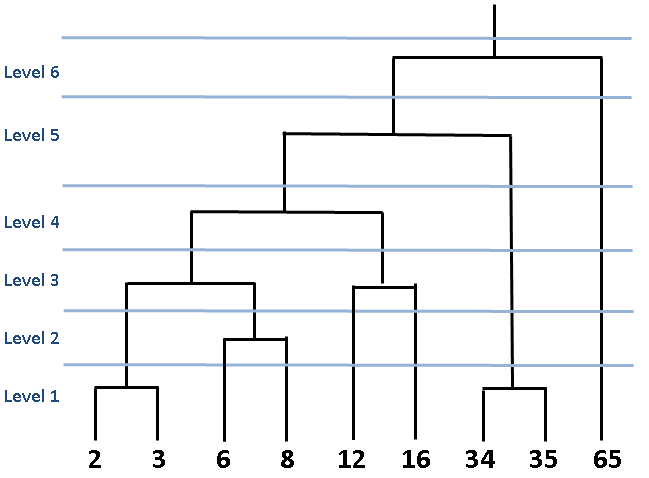


The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

- Single linkage minimizes the distance between the closest observations of pairs of clusters.


Linkages in agglomerative clustering:

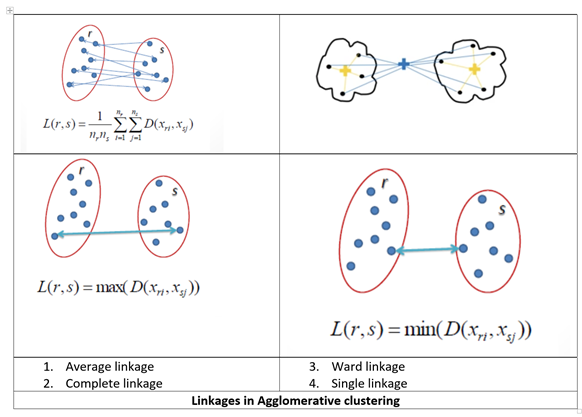

#### Modeling our Country data

In [360]:
# 7.0 Perform Agglomerative clustering
#     Setting distance_threshold=0 ensures we compute the full tree.
# Ref: https://towardsdatascience.com/hierarchical-clustering-explained-e58d2f936323
#      https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

# 7.1
cols = ["TotalPurchases", 	"StockVariety", 	"CustomerCounts"]
model = AgglomerativeClustering(
                                 n_clusters=5,  # Get 5 cluster-labels only
                                )
# 7.2
model = model.fit(X[cols])

# 7.2.1 
X[cols].shape  # (37,3) 37 nodes from 0 to 36

(37, 3)

In [361]:
# 7.3 How clusters have been formed:
z = shc.linkage(model.children_,'ward')
z

array([[ 10.        ,  24.        ,   1.41421356,   2.        ],
       [ 33.        ,  34.        ,   1.41421356,   2.        ],
       [  4.        ,  22.        ,   2.23606798,   2.        ],
       [  2.        ,  11.        ,   2.23606798,   2.        ],
       [ 12.        ,  14.        ,   3.16227766,   2.        ],
       [  7.        ,  36.        ,   3.36650165,   3.        ],
       [ 15.        ,  17.        ,   4.12310563,   2.        ],
       [ 20.        ,  23.        ,   4.12310563,   2.        ],
       [ 28.        ,  29.        ,   4.24264069,   2.        ],
       [ 19.        ,  38.        ,   4.50924975,   3.        ],
       [ 31.        ,  44.        ,   4.96655481,   3.        ],
       [ 32.        ,  37.        ,   5.71547607,   3.        ],
       [ 25.        ,  39.        ,   6.02771377,   3.        ],
       [  0.        ,   6.        ,   6.08276253,   2.        ],
       [  3.        ,   8.        ,   6.08276253,   2.        ],
       [ 27.        ,  43

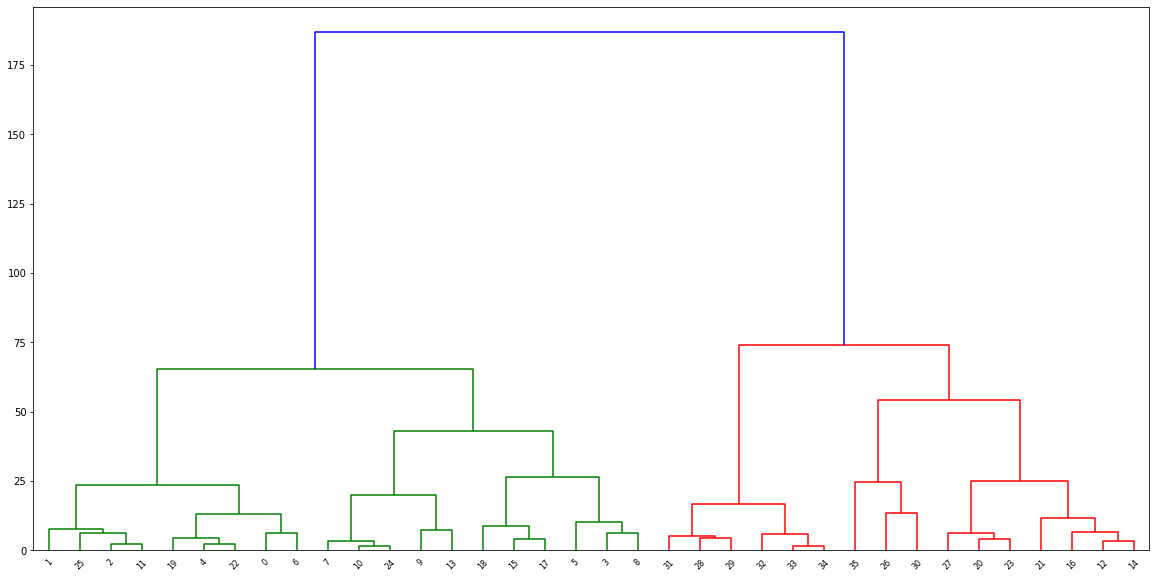

In [362]:
# 7.4 Draw dendogram:

_= plt.figure(figsize = (20,10))
dn = shc.dendrogram(z)  # Total nodes are 36 NOT 37

In [363]:
# Get some details about the dendogram
# Even though countries are 37
# List of leaf-nodes
print(dn['leaves'])
# Maximum listed node number
print(max(dn['leaves']))
# Minimum listed node number
print(min(dn['leaves']))

[1, 25, 2, 11, 19, 4, 22, 0, 6, 7, 10, 24, 9, 13, 18, 15, 17, 5, 3, 8, 31, 28, 29, 32, 33, 34, 35, 26, 30, 27, 20, 23, 21, 16, 12, 14]
35
0


#### Understanding formation of Dendogram

In [364]:
# 8.0 Add two more columns to 
#     our dataset: X

# The following copy is being made
# to avoid a confusion that sometimes 
# arises. Do not modify it.

G = X.copy()

G['Country'] = rcs['Country']
G['c_label'] = model.labels_

# 8.1 Look at X
G.sort_values(by= 'c_label')  

,TotalPurchases,StockVariety,CustomerCounts,Country,c_label
36,-0.202882,-0.424431,-0.179017,Unspecified,0
28,-0.205204,-0.713043,-0.183713,Saudi Arabia,0
27,-0.204404,-0.643720,-0.183713,RSA,0
25,-0.198705,-0.437163,-0.175887,Poland,0
31,-0.171750,-0.356522,-0.172757,Sweden,0
22,-0.203025,-0.585714,-0.182148,Malta,0
21,-0.203800,-0.684748,-0.183713,Lithuania,0
20,-0.203769,-0.662112,-0.183713,Lebanon,0
19,-0.172893,-0.420186,-0.172757,Japan,0
17,-0.198911,-0.413112,-0.179017,Israel,0


In [365]:
# 8.0 Define a function to show relevant
#     rows, given cluster label(s) or nodes:
#     

def showData(label1,label2, label3 = None):
  """
  labelX: cluster labels and NOT node label
          You will get empty dataframe otherwise
  """
  if (label3 is None):
      return G.loc[(G['c_label'] == label1) | (G['c_label'] == label2), :]
  else:
      return G.loc[(G['c_label'] == label1) | (G['c_label'] == label2)| (G['c_label'] == label3), :]    

In [366]:
# 8.2 Now display data, given cluster labels:
#     Note that each value or datapoint is 
#     a z-score value:

print(showData(10,24))
print("xxxxxxx")
print(showData(33,34))
print("xxxxxxx")
print(showData(0,6))

Empty DataFrame
Columns: [TotalPurchases, StockVariety, CustomerCounts, Country, c_label]
Index: []
xxxxxxx
Empty DataFrame
Columns: [TotalPurchases, StockVariety, CustomerCounts, Country, c_label]
Index: []
xxxxxxx
    TotalPurchases  StockVariety  CustomerCounts               Country  c_label
1        -0.196006     -0.291442       -0.168062               Austria        0
2        -0.204821     -0.703140       -0.182148               Bahrain        0
4        -0.204274     -0.680504       -0.183713                Brazil        0
5        -0.201959     -0.517805       -0.179017                Canada        0
8        -0.204674     -0.690407       -0.183713        Czech Republic        0
9        -0.188101     -0.370669       -0.171192               Denmark        0
11       -0.204139     -0.655038       -0.183713    European Community        0
15       -0.201001     -0.530538       -0.179017                Greece        0
16       -0.201369     -0.580055       -0.183713               I

Interpretation of Linkage data with created 


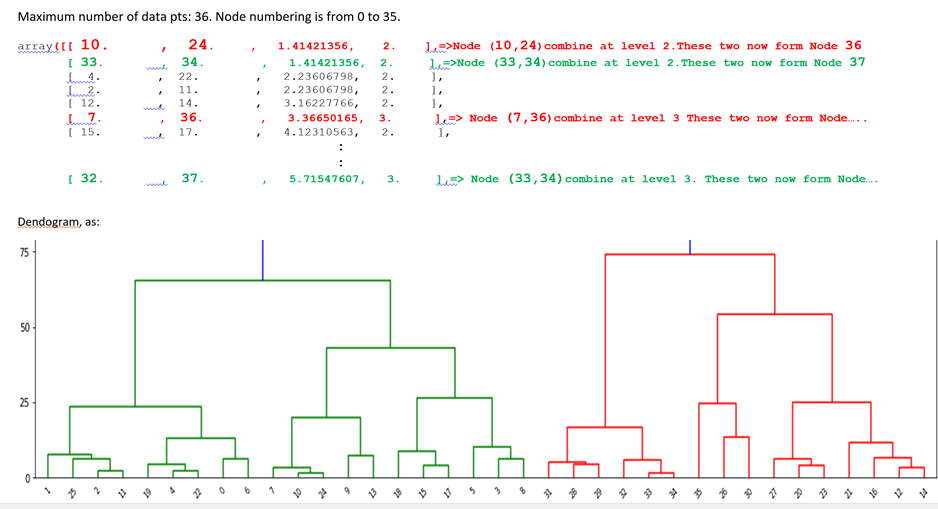

#### Visualize clusters created by hierarchical clustering

In [367]:
# 8.3 Removing UK from data which is totally different
G = G.loc[ ~(G['Country'] == 'United Kingdom'), :]

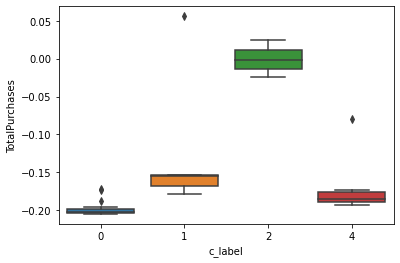

In [368]:
# 8.4 Boxplots for each of the features with respect to ClusterID
_=sns.boxplot(data = G, y = 'TotalPurchases', x = 'c_label')
print()
#_=sns.boxplot(data = G, y = 'StockVariety', x = 'c_label')
print()
#_=sns.boxplot(data = G, y = 'CustomerCounts', x = 'c_label')

###Visualize *rfm* Distributions  

#####Univariate

In [369]:
# 9.1
fig = px.histogram(rfm, x = "frequency")
fig.show()

In [370]:
# 9.2
fig = px.histogram(rfm, x = "recency")
fig.show()

In [371]:
# 9.3
fig = px.histogram(rfm, x = "revenue")
fig.show()

In [372]:
# 9.3.1
fig = px.histogram(rfm, x = "avg_unitprice")
fig.show()

#####Jointplots

In [373]:
# 9.4
fig = px.density_heatmap(
                         rfm,
                         x="frequency",
                         y="recency"
                         )
# 9.4.1. Set x-limits
fig.update_xaxes(range=[0, 50])


In [374]:
# 9.5
fig = px.density_heatmap(
                         rfm,
                         x="frequency",
                         y="recency",
                         marginal_x="histogram"                        
                         )
# 9.5.1 Set x-limits
fig.update_xaxes(range=[0, 25])

In [375]:
# 9.6
fig = px.density_contour(rfm, x="revenue", y="recency")
fig.update_xaxes(range=[0, 10000])

In [376]:
# 9.7
fig = px.density_contour(rfm, x="revenue", y="recency")
_=fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.update_xaxes(range=[0, 10000])

### Removing outliers
How to remove them?

#### About Removing outliers
There is no rigid mathematical definition of what constitutes an outlier; determining whether or not an observation is an outlier is ultimately a subjective exercise. There are various methods of outlier detection. Some are graphical such as normal probability plots. Others are model-based. Box plots are a hybrid.

Model-based methods which are commonly used for identification assume that the data are from a normal distribution, and identify observations which are deemed "unlikely" based on mean and standard deviation: 

Before we cluster data:
>a. Remove outliers<br>
>> i) Use IQR method  
>> ii)Use z-score  
>>iii)Use IsolationForest algorithm  

>b. Perform boxcox transformation to make relevant features symmteric

IQR

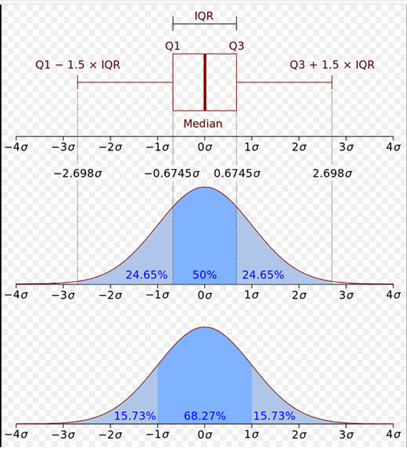



Quantile vs Quartile vs Percentile<br>
Refer [here](https://stats.stackexchange.com/a/156787)

> 0 quartile = 0 quantile = 0 percentile

> 1 quartile = 0.25 quantile = 25 percentile

> 2 quartile = .5 quantile = 50 percentile (median)

> 3 quartile = .75 quantile = 75 percentile

> 4 quartile = 1 quantile = 100 percentile


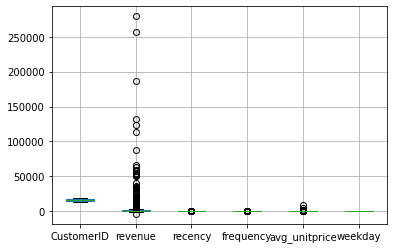

In [67]:
# 10.0 One way to look at outliers in rfm data:

_=rfm.boxplot()

In [377]:
# 10.0.1
cols = ["revenue", "frequency", "recency"]
cols1 = ["revenue", "frequency", "recency", "avg_unitprice"]
cols2 = ["revenue", "frequency", "recency", "avg_unitprice", "weekday"]


### Box-cox transformations

In statistics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like, improve the validity of measures of association such as the Pearson correlation between variables and for other data stabilization procedures. 

#### Variance Stabilization--An example

In [378]:
# 11.0 Last amended: 15th April, 2021
# Myfolder:
# https://stats.stackexchange.com/a/336397

x1 = np.random.lognormal(2,1.3, 500)  # 500 elements
x2 = np.random.lognormal(2,1.3,500)   # 500 elements
X = 2*x1+x2
Y = 2*x2+x1   
D = pd.DataFrame({'x' : X, 'y': Y })
D.head()

,x,y
0,24.841815,23.774573
1,115.162429,106.326572
2,153.931980,90.338463
3,35.235255,51.713313
4,31.780076,22.963264


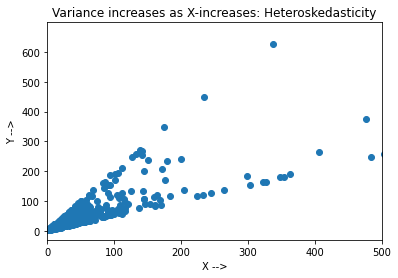

In [379]:
# 11.0.1 Sactter plot of D

_=plt.scatter(D.x,D.y)
_=plt.title("Variance increases as X-increases: Heteroskedasticity")
_=plt.xlim(0,500)
_=plt.xlabel("X -->")
_=plt.ylabel("Y -->")

In [380]:
# 11.1  Define a function to perform
#       boxcox transformation on a dataframe

def boxcox(X):
  """
  X: DataFrame on each feature of
     which transformation is to be carried out
  """
  tr = power_transform(X.values, method = 'yeo-johnson')
  tr = pd.DataFrame(tr, columns= X.columns)
  return tr

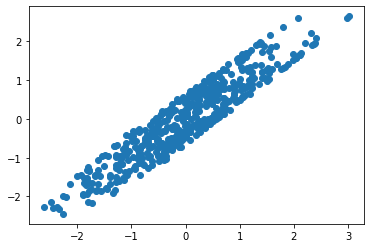

In [381]:
# 11.2 Perform boxcox of D and plot:

D = boxcox(D)
_= plt.scatter(D['x'], D['y'])

#### Boxcox of rfm features
Should boxcox be used?

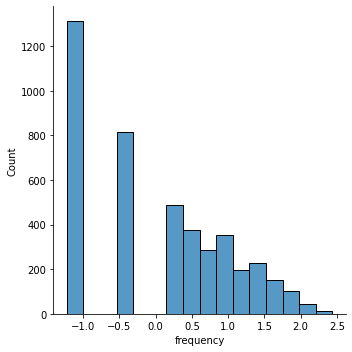

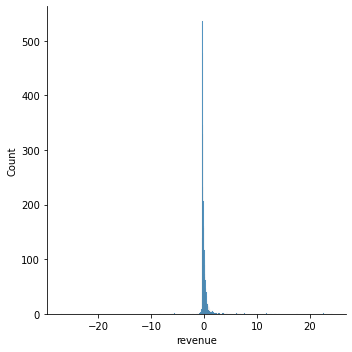

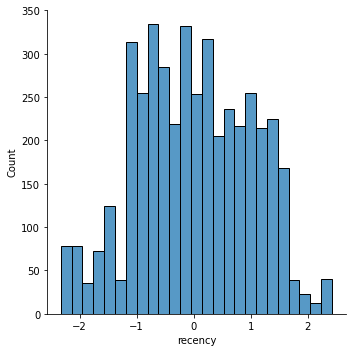

In [382]:
# 11.3
rfm_boxcox = boxcox(rfm[cols])

_=sns.displot(rfm_boxcox, x = "frequency")
_=sns.displot(rfm_boxcox, x = "revenue")
_=sns.displot(rfm_boxcox, x = "recency")
#_=sns.displot(rfm_boxcox, x = "avg_unitprice")

### Statistical methods to remove outliers

#### rfm data: few statistics

In [ ]:
# 12.0 Calculate few stats:

cols = ["revenue", "frequency", "recency"]
print("\n\n----0.99 quantile-----\n")
rfm[cols].quantile(0.99)    # Or 99th percentile

print("\n\n----0.75 quantile-----\n")
rfm[cols].quantile(0.75)    # Or 75th percentile

print("\n\n----0.25 quantile-----\n")
rfm[cols].quantile(0.25)    # Or 25th percentile

# 12.1
print("\n\n----iqr-----\n")
iqr = rfm[cols].quantile(0.75) - rfm[cols].quantile(0.25)

iqr  # rev: 1316, frequency: 4.0, recency: 132,

#### Using IQR to calculate outliers

##### Define a function to remove outliers

In [33]:
# 12.2 Function removes outliers
def rem_outliers(data):
  """
  Given a DataFrame,
  this function removes rows with
  outliers in every feature and returns
  remaining DataFrame.
  """
  for i in range(data.shape[1]):
    # 12.3
    q1 = data.iloc[:,i].quantile(0.25)
    q3 = data.iloc[:,i].quantile(0.75)
    iqr = q3-q1
    # 12.4
    upper_lt = q3 + iqr * 1.5
    lower_lt = q1 - iqr * 1.5
    data = data.loc[(data.iloc[:,i] >lower_lt) & (data.iloc[:,i] < upper_lt), : ]

  # 12.5
  return data  

In [ ]:
# 12.6 Apply the function now to 'rfm'
rfm_aw_iqr = rfm[cols].copy()
rfm_aw_iqr = rem_outliers(rfm_aw_iqr)
rfm_aw_iqr.shape   # (3582, 3)

In [ ]:
# 12.7 Display the inliers:
_=sns.displot(data = rfm_aw_iqr, x = "recency" )
_=sns.displot(data = rfm_aw_iqr, x = "revenue" )
_=sns.displot(data = rfm_aw_iqr, x = "frequency" )


#### Percentile boundaries for outliers
Look at 5th percentile and 95th percentile

In [ ]:
# 13.0 Using percentile as cut-off

#13.1  Removing (statistical) outliers for revenue
lower_rev = rfm.revenue.quantile(0.05)
upper_rev = rfm.revenue.quantile(0.95)
rfm_aw_per = rfm[(rfm.revenue >= lower_rev) & (rfm.revenue <= upper_rev)].copy()

#13.2 Removing (statistical) outliers for recency
lower_rec = rfm.recency.quantile(0.05)
upper_rec = rfm.recency.quantile(0.95)
rfm_aw_per = rfm_aw_per[(rfm_aw_per.recency >= lower_rec) & (rfm_aw_per.recency <= upper_rec)].copy()

#13.3 Removing (statistical) outliers for frequency
lower_freq = rfm.frequency.quantile(0.05)
upper_freq = rfm.frequency.quantile(0.95)
rfm_aw_per = rfm_aw_per[(rfm_aw_per.frequency >= lower_freq) & (rfm_aw_per.frequency <= upper_freq)].copy()

#13.3.1 Removing (statistical) outliers for avg_unitprice
#lower_up = rfm_aw.avg_unitprice.quantile(0.05)
#upper_up = rfm_aw.avg_unitprice.quantile(0.95)
#rfm_aw = rfm_aw[(rfm_aw.avg_unitprice >= lower_up) & (rfm_aw.avg_unitprice <= upper_up)].copy()


# 13.4
rfm_aw_per.shape  # (3538, 6)
rfm_aw_per.head()

In [ ]:
# 13.5 Visualize the inliers data now:
fig = px.histogram(rfm_aw_per, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_aw_per, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_aw_per, x = "revenue", width=600, height=400)
#fig3 = px.histogram(rfm_aw_per, x = "avg_unitprice", width=600, height=400)

fig.show()
fig1.show()
fig2.show()
#fig3.show()

### Isolation forest for outlier removal
See [here](https://quantdare.com/isolation-forest-algorithm/)

#### How does it work?

How do we separate each point? The simple procedure is as follows for each point of the data set:

1.    Select the point to isolate.
2.     For each feature, set the range to isolate between the minimum and the maximum.
3.     Choose a feature randomly.
4.     Pick a value that’s in the range, again randomly:
>i)         If the chosen value keeps the point above, switch the minimum of the range of the feature to the value.  
>ii)        If the chosen value keeps the point below, switch the maximum of the range of the feature to the value.
5. Repeat steps 3 & 4 until the point is isolated. That is, until the point is the only one which is inside the range for all features.
6. Count how many times you’ve had to repeat steps 3 & 4. We call this quantity the isolation number.

The algorithm claims that a point is an outlier if it doesn’t have to repeat the steps 3 & 4 several times.

Isolating anomaly from non-anomaly:

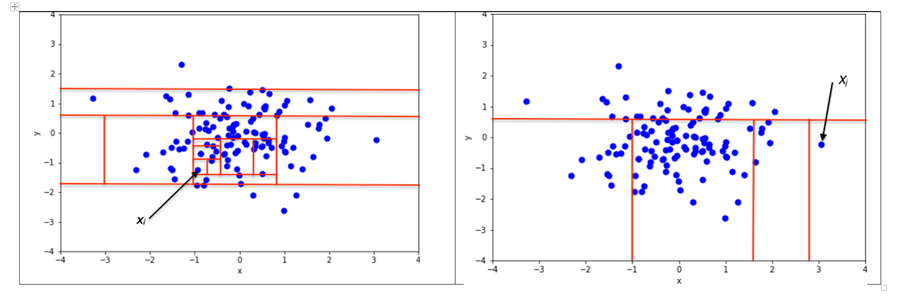

#### Modeling using Isolation forest
Isolation forest need no pre-scaling of data

In [43]:
# 14.0
from sklearn.ensemble import IsolationForest


# 14.0.1 Instantiate a quick model
clf = IsolationForest(random_state=0)

# 14.0.2 Train the model:
clf.fit(rfm[cols].values)

# # 14.0.3 Predict outliers and inliers 
# predict()
#   Returns 'is_inlier' ndarray of shape (n_samples,)
#   For each observation, tells whether or not (+1 or -1)
#   it should be considered as an inlier according to the fitted model.

outlier_labels = clf.predict(rfm[cols].values)
print()
outlier_labels[:10]

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
# 14.0.4 So extract 'normal' data
#        '1' is normal, '-1' is anomaly
rfm_aw_isf = rfm[cols][outlier_labels == 1]
rfm_aw_isf.shape   # (3946, 3)
rfm_aw_isf.head()

##### Visualize non-anomalous data

In [ ]:
# 14.1 Visualize the 'normal' data
fig1 = px.histogram(rfm_aw_isf, x = "revenue", width = 400, height= 400)
fig2 = px.histogram(rfm_aw_isf, x = "frequency", width = 400, height= 400)
fig3 = px.histogram(rfm_aw_isf, x = "recency", width = 400, height= 400)
#fig4 = px.histogram(rfm_aw_isf, x = "avg_unitprice", width = 400, height= 400)

# 14.1.1
fig1.show()
fig2.show()
fig3.show()
#fig4.show()

## Clustering

#### Process inliers for clustering
Scale data from which outliers are removed  
and optionally perform boxcox
We have three sets of non-anomalous data:
- `rfm_aw_iqr`: From IQR boundaries
- `rfm_aw_per`: From percentile boundaries
- `rfm_aw_isf`: From isolation forests

Let us use one of them by turn:

In [83]:
# 15.0 Just rewrite boxcox function
#      once again:

def boxcox(X):
  """
  X: DataFrame on each feature of
     which transformation is to be carried out
  """
  tr = power_transform(X.values, method = 'yeo-johnson')
  tr = pd.DataFrame(tr, columns= X.columns)
  return tr

In [111]:
#15.1 Which dataset to select?
#     We have three of them. Select one:

# 15.2 Percentile without boxcox
#rfm_aw = rfm_aw_per[cols].copy()



# 15.3 
# IQR
#rfm_aw = rfm_aw_iqr[cols].copy()  # (3582, 3)


#15.4
# Isolation forest
rfm_aw = rfm_aw_isf[cols].copy()  # (3946, 3)

# 15.5 
rfm_aw.shape

(3946, 3)

In [112]:
# 15.6 Apply boxcox to selected dataset:

#rfm_aw = boxcox(rfm_aw[cols])
#rfm_aw.shape

In [113]:
# 16.0 Rescaling the attributes

# 16.1 Instantiate
scaler = StandardScaler()

# 16.2 fit_transform
X = scaler.fit_transform(rfm_aw)
X.shape  

(3946, 3)

In [114]:
# 16.3 Transform scaled numpy data to DataFrame
rfm_df_scaled = pd.DataFrame(X)
rfm_df_scaled.columns = cols
rfm_df_scaled.head()

,revenue,frequency,recency
0,3.183875,1.021891,-0.588067
1,0.779173,0.107519,-0.195546
2,0.741190,-0.806854,-0.816082
3,-0.620759,-0.806854,2.367842
4,0.538173,2.241054,-0.229082


### KMeans clustering
We use data without boxcox transformation

#### Scree plot
How many clusters?

In [ ]:
# 18.0 Elbow-curve/SSD
#      We are using rfm_df_scaled that was 
#      created by removing anomalies beyond
#      5% and 95%

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    _=kmeans.fit(rfm_df_scaled[cols])
  
    ssd.append(kmeans.inertia_)
    
# 18.1 plot the SSDs for each n_clusters
_=plt.plot(range_n_clusters,ssd)

#### Silhoutte Score

In [ ]:
# 18.2 Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, algorithm = 'full')
    _=kmeans.fit(rfm_df_scaled[cols])
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

#### Final model

In [118]:
# 18.3 Final model with k=3
#      Why 3? From domain knowledge, I think 3 would be OK.

kmeans = KMeans(n_clusters=3, max_iter=50, algorithm = 'full')
_=kmeans.fit(rfm_df_scaled[cols])

In [ ]:
# 18.4 Assign cluster labels
rfm_df_scaled['cluster_id'] = kmeans.labels_
rfm_df_scaled.head()

### Are clusters interpretable:
Look at clusters, cluster_ID wise


In [ ]:
# 18.5.1 Draw boxplots
#sns.boxplot(x='Cluster_Id', y='revenue', data=rfm_df_scaled);
fig = px.box(rfm_df_scaled, x='cluster_id', y="revenue")
fig.show()

In [ ]:
# 18.5.2 Draw boxplots
#sns.boxplot(x='Cluster_Id', y='recency', data=rfm_aw);
fig = px.box(rfm_df_scaled, x='cluster_id', y="recency")
fig.show()

In [ ]:
# 18.5.3
fig = px.box(rfm_df_scaled, x='cluster_id', y="frequency")
fig.show()
# sns.boxplot(x='cluster_id', y='frequency', data=rfm_aw);

### Gaussian Mixture Model

In [ ]:
# 19.1 Import GaussianMixture class
from sklearn.mixture import GaussianMixture

# 19.2 Instantiate model
#      'tied' with 2 components gives 0.83
gm = GaussianMixture(
                     n_components = 3,
                     n_init = 200,  # The number of initializations 
                                   # to perform. The best results are kept.
                     max_iter = 400,
                     covariance_type= 'tied'
                     )  # 'tied', 'diag', 'full', 


# 19.3
gm.fit(rfm_df_scaled[cols])

# 19.4 Where are the clsuter centers
print("\n-----cluster means----\n")
gm.means_

# 19.5 Did algorithm converge?
print("\n-----Did it converge?----\n")
gm.converged_

# 19.6 How many iterations did it perform?
print("\n-----How many iteratons?----\n")
gm.n_iter_

In [138]:
# 20.0
silhouette_avg = silhouette_score(X = rfm_mix[cols],
                                  metric = 'mahalanobis',
                                  labels =gm.predict(rfm_df_scaled[cols])
                                  )
# 20.1
silhouette_avg

0.39893809864382546

In [128]:
# 21.0 Predict clusters labels
cid = gm.predict(rfm_mix[cols])

In [129]:
# 21.1
rfm_df_scaled['cid'] = cid
rfm_df_scaled.head()
rfm_df_scaled['cid'].value_counts()

,revenue,frequency,recency,cid
0,3.183875,1.021891,-0.588067,0
1,0.779173,0.107519,-0.195546,1
2,0.741190,-0.806854,-0.816082,1
3,-0.620759,-0.806854,2.367842,2
4,0.538173,2.241054,-0.229082,0


1    2501
2     906
0     539
Name: cid, dtype: int64

#### In each cluster, one feature is a distinguishing feature

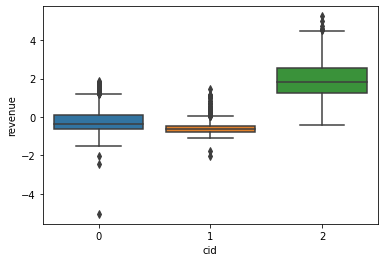

In [75]:
# 22.0
sns.boxplot(x='cid', y='revenue', data=rfm_mix);

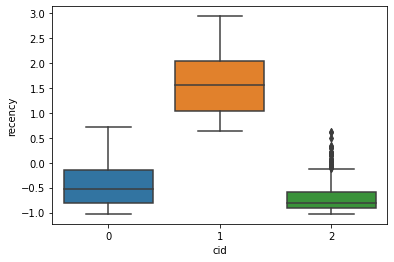

In [76]:
# 22.1
sns.boxplot(x='cid', y='recency', data=rfm_mix);

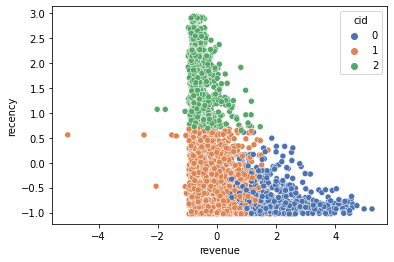

In [136]:
sns.scatterplot(x='revenue', y='recency', hue = 'cid',data=rfm_mix, palette="deep");

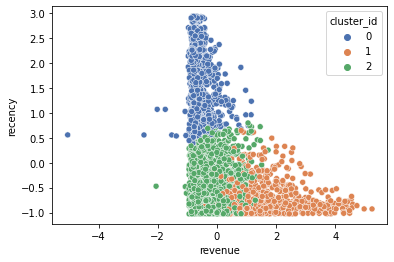

In [135]:
sns.scatterplot(x='revenue', y='recency', hue = 'cluster_id',data=rfm_df_scaled, palette="deep");

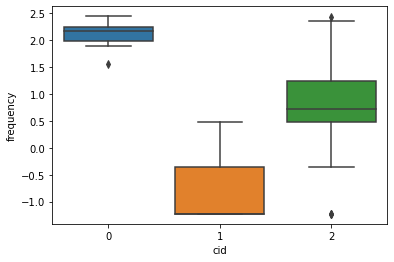

In [509]:
# 22.2
sns.boxplot(x='cid', y='frequency', data=rfm_mix);

> Cluster 1: High revenue + low recency + high frequency  

> Cluster 2: Low revenue + high recency + low frequency  

> Cluster 3: Low revenue + low recency + low frequency  


In [ ]:
############# I am done ###########

In [131]:
bic = []
aic = []
for i in range(10):
    print()
    print("No of clusters: ", i)
    print()
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 80,
                     max_iter = 200,
                     covariance_type= 'tied',
                     init_params="kmeans")
    gm.fit(rfm_df_scaled)
    bic.append(gm.bic(rfm_df_scaled))
    aic.append(gm.aic(rfm_df_scaled))


No of clusters:  0



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=1, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  1



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=2, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  2



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=3, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  3



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=4, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  4



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=5, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  5



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=6, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  6



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=7, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  7



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=8, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  8



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=9, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


No of clusters:  9



GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=200,
                means_init=None, n_components=10, n_init=80,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [512]:
aic
bic

[31734.361341264652,
 24824.21306518298,
 -17578.31653643893,
 -18705.319369241624,
 -19083.350582923595,
 -19316.877269229182,
 -19715.68477820229,
 -20105.027772264482,
 -20265.321231353213,
 -20482.115972495703]

[31820.759777510728,
 24941.468085802655,
 -17430.204931445656,
 -18526.351179874753,
 -18873.525809183124,
 -19076.19591111511,
 -19444.146835714622,
 -19802.633245403216,
 -19932.070120118347,
 -20118.008276887238]

In [407]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
bic = []
aic = []
lowest_bic = np.infty
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gm.fit(rfm_mix[cols])
        bic.append(cv_type + ":" +str(gm.bic(rfm_mix[cols])))
        aic.append(cv_type + ":" +str(gm.aic(rfm_mix[cols])))
        if gm.bic(rfm_mix[cols]) < lowest_bic:
            lowest_bic = gm.bic(rfm_mix[cols])
            best_gm = gm

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=12, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=13, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=14, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=12, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=13, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=14, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=12, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=13, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=14, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=12, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=13, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=14, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [ ]:
aic
print()
bic

In [533]:
rfm_mix.to_csv("rfm_mix.csv",index=False)

In [ ]:
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="time")

In [ ]:
####### I am done ##############